## Product Reorder Recommendation Using E-Commerce Dataset
* Recomend products that customers are highly likely to reorder


## Content
* Import data
* Data Exploration
* Data Quality Check
* Feature Engineering
* Model Training and Evaluation
* Conclusions

## Import Data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from collections import OrderedDict
import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Data/eCommerce/'

/content/drive/MyDrive/Data/eCommerce


In [ ]:
aisles = pd.read_csv('aisles.csv') 
departments = pd.read_csv('departments.csv') 
order_products_prior = pd.read_csv('order_products_prior.csv') # ?
order_products_train = pd.read_csv('order_products_train.csv') # ?
orders = pd.read_csv('orders.csv') 
products = pd.read_csv('products.csv') 

In [ ]:
aisles.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


In [ ]:
orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0


In [ ]:
order_products_train.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1


In [ ]:
order_products_prior.head(2)

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1


## Data Exploration

### Build Order History Dataset

In [ ]:
prior_order_details = order_products_prior.merge(orders, on="order_id")
prior_order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
# Covert Days of week column in to day infomation
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Sunday" if x==0 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Monday" if x==1 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Tuesday" if x==2 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Wednesday" if x==3 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Thursday" if x==4 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Friday" if x==5 else x)
prior_order_details["order_dow"] = prior_order_details["order_dow"].apply(lambda x:"Saturday" if x==6 else x)

In [ ]:
prior_order_details.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0


### Visualize Order Data

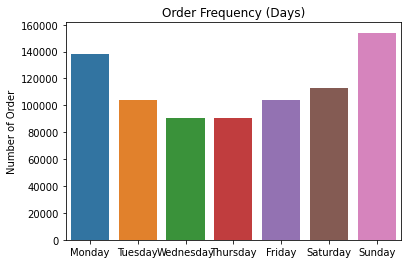

In [ ]:
# Frequency of order based ond days of week
ax = sns.countplot(x="order_dow",data=prior_order_details,
                   order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Order Frequency (Days)")
plt.xlabel("")
plt.ylabel("Number of Order")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


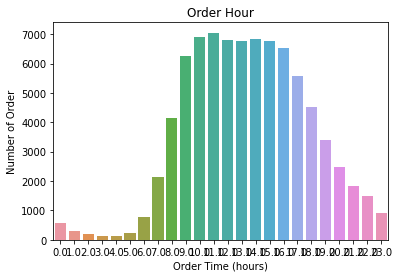

In [ ]:
# Frequecny of order based hour of the day
order_hours_counts = orders.groupby("order_id")["order_hour_of_day"].mean().reset_index()
order_hod_stats = order_hours_counts.order_hour_of_day.value_counts()
sns.barplot(order_hod_stats.index, order_hod_stats.values)
plt.title("Order Hour")
plt.ylabel("Number of Order")
plt.xlabel('Order Time (hours)')
plt.show()

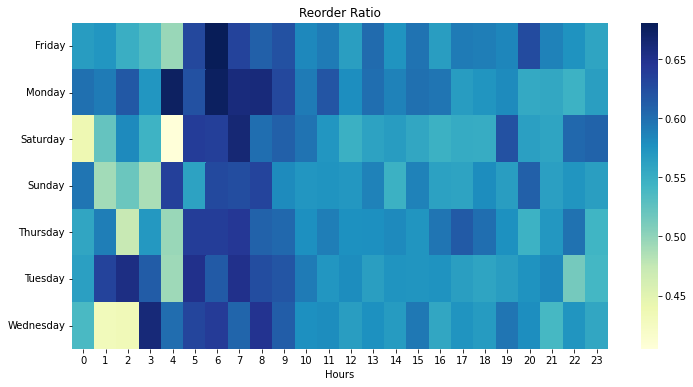

In [ ]:
# Reorder pattern analysis
# High correlations concentrate around 6 to 9 on Friday and Monday (happy buy/sad buy)
reorder_heatmap = prior_order_details.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_heatmap = reorder_heatmap.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(12,6))
sns.heatmap(reorder_heatmap,cmap="YlGnBu")
plt.title("Reorder Ratio")
plt.ylabel("")
plt.xlabel("Hours")
plt.show()

In [ ]:
# Top 3 popular porducts 
Top_3_products = products.groupby('product_name').sum().sort_values('product_id',ascending = False).index[:3]
Top_3_products

Index(['Fresh Foaming Cleanser', 'Smartblend Healthy Metabolism Dry Cat Food',
       'Artisan Baguette'],
      dtype='object', name='product_name')

## Data Quality Check

#### Validate the days since the last order column in orders

In [ ]:
orders.head() 

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
# missing data only present when order_number == 1. It also matches with user number
print("Value size of the order dataset: ", orders.shape[0])
print("NaN count in days_since_prior_order column: ", orders[orders.days_since_prior_order.isnull()].shape[0])
print("order_number 1 count in orders table: ", orders[orders.order_number == 1].drop_duplicates().shape[0])
print("user_id count in orders table: ", orders.user_id.drop_duplicates().shape[0])

Value size of the order dataset:  82683
NaN count in days_since_prior_order column:  5000
order_number 1 count in orders table:  5000
user_id count in orders table:  5000


####  Valid orders check 

In [ ]:
orders.groupby('eval_set',as_index=False).agg(OrderedDict([('order_id','nunique')]))

,eval_set,order_id
0,prior,77683
1,train,5000


In [ ]:
# order numbers in pior match with order number in orders
print("order_id count in prior: ", order_products_prior['order_id'].nunique())
print("order_id from prior found in orders: ", order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique())

order_id count in prior:  77683
order_id from prior found in orders:  77683


In [ ]:
# order number in train matches with order number in orders
print("orders count in train: ", order_products_train['order_id'].nunique())
print("order_id from train found in orders: ", order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique())

orders count in train:  5000
order_id from train found in orders:  5000


In [ ]:
# no overlap between train and prior data
print("order_id intersection between prior and train: ", pd.merge(order_products_prior, order_products_train, on = ['order_id']).shape[0])

order_id intersection between prior and train:  0


In [ ]:
# same users are used in train and pior in orders
prior_user_ids = set(orders[orders['eval_set'] == 'prior']['user_id'])
train_user_ids = set(orders[orders['eval_set'] == 'train']['user_id'])
print("user_ids in prior: ", len(prior_user_ids))
print("user_ids in train: ", len(train_user_ids))
print("intersection of prior and train: ", len(prior_user_ids.intersection(train_user_ids)))

user_ids in prior:  5000
user_ids in train:  5000
intersection of prior and train:  5000


## Feature Engineering 

### Construct Features

#### Construct Target Feature - Labels
* product has been ordered- label = 1
* product hasn't been ordered - label = 0

In [ ]:
orders.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0


In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


In [ ]:
train_details = order_products_train.merge(orders, on = 'order_id')
train_user_ids = set(orders[orders['eval_set'] == 'train']['user_id'])
train_unique_key = train_details['user_id'].astype('str') + '_' + train_details['product_id'].astype('str')
train_unique_key.head()

0    173934_13176
1    173934_39922
2     173934_5258
3    173934_21137
4     129386_6046
dtype: object

In [ ]:
prior_details = order_products_prior.merge(orders, on = 'order_id')
model_all_data = prior_details[prior_details.user_id.isin(train_user_ids)][['user_id','product_id','order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
model_all_data = model_all_data.drop_duplicates(subset=['user_id', 'product_id']) 
model_all_data['unique_key'] = model_all_data['user_id'].astype('str') + '_' + model_all_data['product_id'].astype('str')
model_all_data.head(2)

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key
0,152610,30597,22,6,8,10.0,152610_30597
1,152610,15221,22,6,8,10.0,152610_15221


In [ ]:
model_all_data['label'] = 0
model_all_data.loc[model_all_data.unique_key.isin(train_unique_key), 'label'] = 1
model_all_data.head(2)

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label
0,152610,30597,22,6,8,10.0,152610_30597,0
1,152610,15221,22,6,8,10.0,152610_15221,0


#### Construct Product-User Features

In [ ]:
# construct user product features and merge with all data
user_product_features = ['user_product__total_orders',
                         'user_product__add_to_cart_order_mean',
                         'user_product__reordered_mean',
                         'user_product__most_dow',
                         'user_product__most_hod']
prior_details.head(2)
df_user_product_features = (prior_details.groupby(['product_id','user_id'],as_index=False) 
                                           .agg(OrderedDict(
                                                   [('order_id','count'), 
                                                    ('add_to_cart_order','mean'), 
                                                    ('reordered', 'mean'), 
                                                    ('order_dow', (lambda x: x.mode()[0])), 
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])), 
                                                    ])))
df_user_product_features.columns = ['product_id', 'user_id'] + user_product_features

model_all_data = model_all_data.merge(df_user_product_features, on = ['user_id', 'product_id'])
model_all_data.head(2)

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,user_product__reordered_mean,user_product__most_dow,user_product__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,0.800,6,13
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,0.875,4,9


#### Construct Product Features

In [ ]:
product_features = ['product__total_orders',
                     'product__add_to_cart_order_mean',
                     'product__total_users',
                     'product__reordered_mean',
                     'product__most_dow',
                     'product__most_hod',
                     'product__days_since_prior_order_mean'
                     ]

df_product_features = (prior_details.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'), 
                                                    ('add_to_cart_order','mean'), 
                                                    ('user_id', 'nunique'), 
                                                    ('reordered', 'mean'), 
                                                    ('order_dow', (lambda x: x.mode()[0])), 
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])), 
                                                    ('days_since_prior_order', 'mean') 
                                                    ])))
df_product_features.columns = ['product_id'] + product_features
model_all_data = model_all_data.merge(df_product_features, on = ['product_id'])
model_all_data = model_all_data.merge(products[['product_id','aisle_id', 'department_id']], on = ['product_id'])
model_all_data.rename(columns={'aisle_id': 'product__aisle_id', 'department_id': 'product__department_id'}, inplace=True)
model_all_data.head(2)

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,user_product__most_hod,product__total_orders,product__add_to_cart_order_mean,product__total_users,product__reordered_mean,product__most_dow,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.0,...,13,85,4.2,23,0.729412,3,9,12.592593,53,16
1,112604,30597,15,3,10,1.0,112604_30597,0,5,3.8,...,10,85,4.2,23,0.729412,3,9,12.592593,53,16


#### Construct User Features

In [ ]:
user_features = ['user__order_count',
                  'user__product_count',
                  'user__days_since_prior_order_mean',
                  'user__reordered_mean',
                  'user__most_dow',
                  'user__most_hod',
                  ]

df_user_features = (prior_details.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('product_id','count'),
                                                    ('days_since_prior_order','mean'),
                                                    ('reordered', 'mean'), 
                                                    ('order_dow', (lambda x: x.mode()[0])), 
                                                    ('order_hour_of_day', (lambda x: x.mode()[0])),
                                                    ])))
df_user_features.columns = ['user_id'] + user_features
model_all_data = model_all_data.merge(df_user_features, on = ['user_id'])
model_all_data.head(2)

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,product__most_hod,product__days_since_prior_order_mean,product__aisle_id,product__department_id,user__order_count,user__product_count,user__days_since_prior_order_mean,user__reordered_mean,user__most_dow,user__most_hod
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,...,9,12.592593,53,16,26,408,10.953804,0.375,6,12
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,...,12,13.653846,84,16,26,408,10.953804,0.375,6,12


In [ ]:
model_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329806 entries, 0 to 329805
Data columns (total 28 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   user_id                               329806 non-null  int64  
 1   product_id                            329806 non-null  int64  
 2   order_number                          329806 non-null  int64  
 3   order_dow                             329806 non-null  int64  
 4   order_hour_of_day                     329806 non-null  int64  
 5   days_since_prior_order                299811 non-null  float64
 6   unique_key                            329806 non-null  object 
 7   label                                 329806 non-null  int64  
 8   user_product__total_orders            329806 non-null  int64  
 9   user_product__add_to_cart_order_mean  329806 non-null  float64
 10  user_product__reordered_mean          329806 non-null  float64
 11  

In [ ]:
model_all_data['label'].value_counts()

0    297467
1     32339
Name: label, dtype: int64

### Feature Transformation

In [ ]:
label_count = model_all_data.label.value_counts() # The data is imbalance, but it is acceptable and very comon in industry data
print("Negative label count: ", label_count[0])
print("Positive label count: ", label_count[1])
print("Positive label rate is {:.2f}%".format(
      label_count[1] / (label_count[0] + label_count[1]) * 100) )

Negative label count:  297467
Positive label count:  32339
Positive label rate is 9.81%


In [ ]:
# There are saome missing values in thress features, and they will be filled with 0.0 in data pipeline in this dataset
model_all_data.isna().sum() 

user_id                                     0
product_id                                  0
order_number                                0
order_dow                                   0
order_hour_of_day                           0
days_since_prior_order                  29995
unique_key                                  0
label                                       0
user_product__total_orders                  0
user_product__add_to_cart_order_mean        0
user_product__reordered_mean                0
user_product__most_dow                      0
user_product__most_hod                      0
product__total_orders                       0
product__add_to_cart_order_mean             0
product__total_users                        0
product__reordered_mean                     0
product__most_dow                           0
product__most_hod                           0
product__days_since_prior_order_mean      726
product__aisle_id                           0
product__department_id            

#### Categorical Feature Encoding

In [ ]:
model_all_data = pd.get_dummies(model_all_data, columns=["product__department_id"],prefix='product__department_id_')
model_all_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,unique_key,label,user_product__total_orders,user_product__add_to_cart_order_mean,...,product__department_id__12,product__department_id__13,product__department_id__14,product__department_id__15,product__department_id__16,product__department_id__17,product__department_id__18,product__department_id__19,product__department_id__20,product__department_id__21
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,...,0,0,0,0,1,0,0,0,0,0
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,...,0,0,0,0,1,0,0,0,0,0
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,...,0,0,0,0,0,0,0,0,0,0
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,...,0,0,0,0,1,0,0,0,0,0
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,...,0,0,0,0,0,0,0,0,0,0


## Model Training and Evaluation

#### Model Training and Selection

In [ ]:
# divided model_all_data into training, validation, and testing 
test_user_ids = model_all_data.user_id.drop_duplicates().sample(frac=0.2)
train_validation_data = model_all_data[~model_all_data.user_id.isin(test_user_ids)]
test_data = model_all_data[model_all_data.user_id.isin(test_user_ids)]
train_validation_data_x = train_validation_data.drop(['user_id', 'product_id', 'label'],axis=1)
train_validation_data_y = train_validation_data['label']

In [ ]:
# Define nerual network model
def create_model():
    model = keras.Sequential([
        ### layer input
        keras.layers.Dense(30, input_dim=train_validation_data_x.shape[1], activation='relu'),
        ###  layer 1
        keras.layers.Dense(15, activation='relu'),
        ###  layer 2
        keras.layers.Dense(5, activation='relu'),
        ### layer output
        keras.layers.Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

NN_model = KerasClassifier(build_fn=create_model, epochs=64, batch_size=32, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  app.launch_new_instance()


In [ ]:

classifiers = [
    # NN_model neural network model taks to long to train in this free version and will leave out for now/ doing feature selection first
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ]

def build_ml_pipeline(classifier):
  steps = list()
  steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0))) # fill missing value with 0.0
  steps.append(('downSample', RandomUnderSampler())) # remove imbalance data influences
  steps.append(('scaler', MinMaxScaler())) # nuermical features normalization
  steps.append(('model', classifier))
  pipeline = Pipeline(steps=steps)
  return pipeline

In [ ]:
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_data_x, train_validation_data_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

  ## Graident Boosting Model has the best performance

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 23.5 s, sys: 5.72 s, total: 29.2 s
Wall time: 23.8 s
LogisticRegression : F1 value is 34.835 (2.254)
CPU times: user 19.3 s, sys: 1.06 s, total: 20.3 s
Wall time: 22.4 s
DecisionTreeClassifier : F1 value is 25.007 (1.297)
CPU times: user 1min 21s, sys: 1.81 s, total: 1min 23s
Wall time: 1min 24s
RandomForestClassifier : F1 value is 33.622 (2.585)
CPU times: user 46.5 s, sys: 949 ms, total: 47.5 s
Wall time: 51.1 s
AdaBoostClassifier : F1 value is 34.367 (2.949)
CPU times: user 2min 9s, sys: 915 ms, total: 2min 10s
Wall time: 2min 18s
GradientBoostingClassifier : F1 value is 35.307 (2.893)


#### Feature Selection

In [ ]:
pipeline = build_ml_pipeline(GradientBoostingClassifier())
pipeline.fit(train_validation_data_x, train_validation_data_y)
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x.columns.tolist()

df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
top15_features = df_importances.head(15)    
top15_features

,feature,importance
7,user_product__reordered_mean,0.298481
18,user__order_count,0.287647
5,user_product__total_orders,0.212892
0,order_number,0.075700
13,product__reordered_mean,0.072783
21,user__reordered_mean,0.016301
10,product__total_orders,0.008807
19,user__product_count,0.004501
20,user__days_since_prior_order_mean,0.003752
3,days_since_prior_order,0.003633


In [ ]:
#Retrain model with selected features
train_validation_data_x_select_features = train_validation_data_x[top15_features['feature']]

### Hyperparameter Tuning (5% data)

In [ ]:
# Due to limited computing resources, only 10% of data are used to tuning gradient boosting models
sample_user_ids = train_validation_data.user_id.drop_duplicates().sample(frac=0.05)
train_validation_data_sample = train_validation_data[train_validation_data.user_id.isin(sample_user_ids)]
train_validation_data_sample_x = train_validation_data_sample.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
train_validation_data_sample_y = train_validation_data_sample['label']


In [ ]:
param_grid = {
    'model__n_estimators': [100,150],
    'model__max_depth': [4,6],
    'model__min_samples_split': [2,4,6],
    'model__learning_rate': [0.005, 0.01],
}
grid = GridSearchCV(build_ml_pipeline(GradientBoostingClassifier()), cv=5, param_grid=param_grid, scoring='f1')
grid.fit(train_validation_data_sample_x, train_validation_data_sample_y)
print("Best F1 value is %.3f" % grid.best_score_)
print("Params are %s" % grid.best_params_)

Best F1 value is 0.342
Params are {'model__learning_rate': 0.005, 'model__max_depth': 4, 'model__min_samples_split': 2, 'model__n_estimators': 150}


### Finalize Model

In [ ]:
pipeline = build_ml_pipeline(GradientBoostingClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=4,
    learning_rate=0.005,
))

pipeline.fit(train_validation_data_x_select_features, train_validation_data_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.005, max_depth=4))])

In [ ]:
importances = pipeline.steps[3][1].feature_importances_
feature_names=train_validation_data_x_select_features.columns.tolist()
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances}).sort_values("importance", ascending=False)
df_importances.head(15)

,feature,importance
0,user_product__reordered_mean,0.343465
2,user_product__total_orders,0.308624
1,user__order_count,0.288683
3,order_number,0.031023
4,product__reordered_mean,0.024244
6,product__total_orders,0.003389
8,user__days_since_prior_order_mean,0.000462
10,product__department_id__13,0.000110
5,user__reordered_mean,0.000000
7,user__product_count,0.000000


### Model Evaluation

In [ ]:
test_data_x_selected_features = test_data.drop(['user_id', 'product_id', 'label'],axis=1)[top15_features['feature']]
test_data_y = test_data['label']
predict_y = pipeline.predict(test_data_x_selected_features)
df_output = pd.DataFrame(
    {"user_id":test_data.user_id, "product_id":test_data.product_id, "predict":predict_y, "label":test_data.label})   
df_output.head(20)

,user_id,product_id,predict,label
1085,22499,30597,1,1
1086,22499,21333,0,0
1087,22499,5450,0,0
1088,22499,49383,0,0
1089,22499,14992,0,0
1090,22499,47815,1,1
1091,22499,33956,0,0
1092,22499,34861,0,0
1093,22499,18709,0,0
1094,22499,35102,1,1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


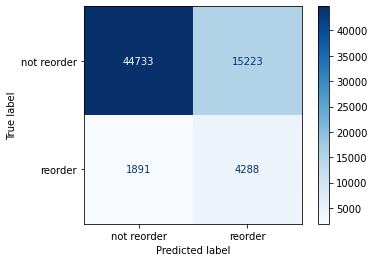

In [ ]:
predict_y_prob = pipeline.predict_proba(test_data_x_selected_features)[:,1]
plot_confusion_matrix(pipeline, test_data_x_selected_features, test_data_y,
                      display_labels=["not reorder","reorder"],cmap=plt.cm.Blues)

In [ ]:
acc = accuracy_score(test_data_y, predict_y)
f1 = f1_score(test_data_y, predict_y)
pre = precision_score(test_data_y, predict_y)
rec = recall_score(test_data_y, predict_y)
auc = roc_auc_score(test_data_y, predict_y_prob)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 33.3826%
ROC AUC : 79.7254%
Accuracy : 74.1226%
Precision : 21.9773%
Recall : 69.3963%


## Conclusions
* Gradient Boosting has the best overall performance (time and F1 score).
* The top 15 features that influencing customer reorder behavior are:
'user_product__reordered_mean',

 'user_product__total_orders',
 'user__order_count',
 'order_number',
 'product__reordered_mean',
 'product__total_orders',
 'user__days_since_prior_order_mean',
 'product__department_id__13',
 'user__reordered_mean',
 'user__product_count',
 'days_since_prior_order',
 'product__total_users',
 'product__add_to_cart_order_mean',
 'user_product__add_to_cart_order_mean',
 'product__days_since_prior_order_mean'